## Library and Initalization

Define your search path for Bovy's libraries.

In [1]:
import sys
sys.path.insert(0, "/Users/john/Desktop/bovy_code/mwdust-master")
sys.path.insert(0, "/Users/john/Desktop/bovy_code/gaia_tools-master")
sys.path.insert(0, "/Users/john/Desktop/bovy_code/tgas-completeness-master/py")
sys.path.insert(0, "/Users/john/Desktop/bovy_code/isodist-master")

%env GAIA_TOOLS_DATA=/Users/john/Desktop/bovy_code/gaia_tools-master
%env DUST_DIR=/Users/john/Desktop/bovy_code/mwdust-master

env: GAIA_TOOLS_DATA=/Users/john/Desktop/bovy_code/gaia_tools-master
env: DUST_DIR=/Users/john/Desktop/bovy_code/mwdust-master


The first few blocks import all the libraries. I receive **RunTimeError** messages from running *import numpy* concerning the version compatibility, but the program still runs anyways so I neglected it. There might also be *warning* message concerning Jo Bovy's *effsel.py*, which should not affect the code's running.

The middle block contains just the variables Jo Bovy used to select tracer stars. Except for "*max_plx_error*", it is specific to Schutz's analysis to control the statistical behavior for the parallax uncertainty.

The last two blocks Jovy Bovy's functions for the proper evfs generation.

In [2]:
import os
import pylab
import numpy as np
import healpy

import matplotlib.pyplot as plt
from astropy import units
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic
from galpy.util import bovy_plot, bovy_coords, save_pickles, multi
from galpy.util.bovy_coords import cov_pmrapmdec_to_pmllpmbb

import tqdm
from scipy import interpolate, optimize, integrate
import mwdust
import effsel
from isodist import Z2FEH, imf, PadovaIsochrone
import gaia_tools.load, gaia_tools.select
from effsel import main_sequence_cut_r, giant_sequence_cut

%matplotlib inline


min_plx= 0.45/0.2
max_dist = 1./min_plx
tsf_jmin= 2.
max_plx_error = 0.4

def cyl_vol_func(X,Y,Z,xymin=0.,xymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in cylindrical annuli around the Sun"""
    xy = np.sqrt(X**2.+Y**2.)
    out = np.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out

def is_good_relplx(mj):
    out= np.empty_like(mj)
    out[mj > 5.] = 20.
    out[mj < 0.] = 10.
    out[(mj >= 0)*(mj <= 5.)] = 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

/Users/john/Desktop/bovy_code/tgas-completeness-master/py/effsel.py:32: RuntimeWarning: invalid value encountered in less_equal
  sp_indx*= (numpy.roll((sp['JH']+sp['HK']),1)-(sp['JH']+sp['HK'])) <= 0.



Standard initialization for the color spectrum, gaia data loading and absolute luminosity calculation. Color description using Johnson's **B-V** is possible but will not be implemented in this notebook. (Due to the heavy use of G stars)

In [3]:
sp= effsel.load_spectral_types()
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
#bv = twomass['b_m_opt']-twomass['vr_m_opt']
jk = twomass['j_mag']-twomass['k_mag']
dm = -5.*np.log10(tgas['parallax'])+10.
mj = twomass['j_mag']-dm

tsf= gaia_tools.select.tgasSelect( max_plxerr=max_plx_error )
tsf._jmin= tsf_jmin

/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:133: RuntimeWarning: invalid value encountered in greater
  *(self._full_twomass['j_mag'] < 10.)

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:133: RuntimeWarning: invalid value encountered in less
  *(self._full_twomass['j_mag'] < 10.)

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:173: RuntimeWarning: invalid value encountered in greater
  *(self._full_twomass['j_mag'] < jmax)

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:173: RuntimeWarning: invalid value encountered in less
  *(self._full_twomass['j_mag'] < jmax)

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:195: RuntimeWarning: invalid value encountered in divide
  numpy.nanmedian((nstartgas

## Data cut flow of star density

We introduce our cut flow modules.

*cut_flow* : A function to streamline a list of cuts in the variable *cuts*. It takes a data array in the argument and return a length-reduced data with the cuts implemented. Arguments:
    - data - np.array. Input data array.
    - cuts - a list of boolean arrays. Each boolean array specifies which entries in *data* are to be removed.
    
Then we introduce our first cut. The *cut_general*,

*cut_general* : Return a single-elemented boolean cut array list. It select the "good" statistics entries from the tgas data set. The return value is to be used by the *cut_flow* function.

All future (more complicated) cuts will follow this programming flow.

In [4]:
def cut_flow(data, cuts):
   for i, cut_indx in enumerate(cuts):
      data = data[cut_indx]
   return data

def cut_general(tgas):
   stat_indx = tsf.determine_statistical(tgas,twomass['j_mag'],twomass['k_mag'])
   tgas=tgas[stat_indx]
   return [stat_indx]

init_cuts = cut_general(tgas)

tgas = cut_flow(tgas, init_cuts)
twomass = cut_flow(twomass, init_cuts)
jk= cut_flow(jk, init_cuts)
dm= cut_flow(dm, init_cuts)
mj= cut_flow(mj, init_cuts)

print( 'tgas entry count: ', len(tgas) ) 

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:284: RuntimeWarning: invalid value encountered in greater_equal
  *(j-k >= self._jkmin)*(j-k <= self._jkmax)

/Users/john/Desktop/bovy_code/gaia_tools-master/gaia_tools/select/tgasSelect.py:284: RuntimeWarning: invalid value encountered in less_equal
  *(j-k >= self._jkmin)*(j-k <= self._jkmax)

('tgas entry count: ', 1075864)


A cylindrical cut which cuts away stars with r > r_cyl_cut and |z| > z_cyl_cut in a cylindrical volume. Introducing a completeness volume early on will save computation time in the upcoming steps.

In [5]:
r_cyl_cut = 0.15
z_cyl_cut = 0.22

def cut_indx_vol(tgas, rcut, zcut):

   XYZ= bovy_coords.lbd_to_XYZ(tgas['l'],tgas['b'],1./tgas['parallax'],degree=True)
   r_cyl = np.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
   z_cyl= XYZ[:,2]

   return  [(r_cyl < r_cyl_cut)*(np.abs(z_cyl) < z_cyl_cut)]

vol_cut_indx = cut_indx_vol(tgas, r_cyl_cut, z_cyl_cut)
jk_cyl = cut_flow(jk, vol_cut_indx)
mj_cyl = cut_flow(mj, vol_cut_indx)
tgas_cyl = cut_flow(tgas, vol_cut_indx)

print( 'Vol-reduced tgas entry count: ', len(tgas_cyl) ) 

('Vol-reduced tgas entry count: ', 76873)


A module for dereddening. It is optional at this moment.

In [6]:
dereddening = False
load_dereddened_data = False

jk_corr = np.zeros_like(jk_cyl)
mj_corr = np.zeros_like(mj_cyl)

if (dereddening) and (not load_dereddened_data):
   print("loading dust map...")
   #dust_combine = mwdust.Combined15()  #b-v filter
   dust_combine_J = mwdust.Combined15("2MASS J")
   dust_combine_K = mwdust.Combined15("2MASS Ks")
   print("Preparing dereddening...")
   for i in tqdm.tqdm(range(len(jk_cyl))):
      ldeg = (tgas_cyl['l'])[i]
      bdeg = (tgas_cyl['b'])[i]
      plx = (tgas_cyl['parallax'])[i]   
      ej = dust_combine_J(ldeg,bdeg,np.divide(1000.,plx))
      ek = dust_combine_K(ldeg,bdeg,np.divide(1000.,plx))
      ejk = ej-ek
      #ebv = dust_combine(ldeg,bdeg,np.divide(1000.,plx))
      #bv_corr[i] = bv_cyl[i] - ebv
      jk_corr[i] = jk_cyl[i] - ejk
      mj_corr[i] = mj_cyl[i] - ej
   dereddened_ouput_file = "temp_ext.txt"
   np.savetxt(dereddened_ouput_file, np.transpose( np.array([jk_corr, mj_corr]) ), delimiter=',',header="B-V, M_j")
   print("dereddening complete! File saved to: ", dereddened_ouput_file)

if dereddening and load_dereddened_data:
   print("loading dereddened data")
   JKCOLUMN = 0; MJCOLUMN = 1
   file_deredden = "temp_ext.txt" 
   jk_corr, mj_corr = np.genfromtxt(file_deredden, delimiter= ",", usecols=(JKCOLUMN, MJCOLUMN), unpack=True, skip_header=1)

*find_jk_boundaries* : A function to find the color boundaries for a star category. Return a *2-tuple* with the first element being the "upper" boundary (smaller j-k) and the second element the "lower" boundary (larger j-k). Arguments:
    - starCategory - string. The star's (sub-)category.
    - sp - Jo Bovy's effsel spectral class array.

I have defined the color boundaries for each star category to be the midpoints between its own midpoint and the midpoint of the adjacent star categories. Supported classes are
- **All** stars
- **A**, **F**, and **G** which contains only G0V to G4V
- **Letter** + **number** labeled all subcategories, e.g. A0, G5, etc.

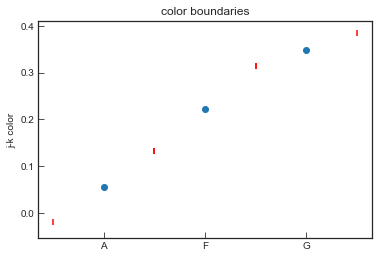

In [7]:
def find_jk_boundaries(starCategory, sp):

   sp_stars = lambda star_Cat: np.array([( str(star_Cat) in s) for s in sp['SpT'] ], dtype='bool')
   jk_color_cut_upper = float("nan")
   jk_color_cut_lower = float("nan")

   # First consider the input as main classes
   if starCategory == "A":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('B9V') ] + (sp['JH']+sp['HK'])[ sp_stars('A0V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('A9V') ] + (sp['JH']+sp['HK'])[ sp_stars('F0V') ]  )/2
   elif starCategory == "F":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('A9V') ] + (sp['JH']+sp['HK'])[ sp_stars('F0V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('F9V') ] + (sp['JH']+sp['HK'])[ sp_stars('G0V') ]  )/2
   elif starCategory == "G": # THIS IS A SHORT-LISTED G CATEGORY
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('F9V') ] + (sp['JH']+sp['HK'])[ sp_stars('G0V') ]  )/2 
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('G4V') ] + (sp['JH']+sp['HK'])[ sp_stars('G5V') ]  )/2
   elif starCategory == "All":
      jk_color_cut_upper = (  (sp['JH']+sp['HK'])[ sp_stars('B9V') ] + (sp['JH']+sp['HK'])[ sp_stars('A0V') ]  )/2
      jk_color_cut_lower = (  (sp['JH']+sp['HK'])[ sp_stars('G4V') ] + (sp['JH']+sp['HK'])[ sp_stars('G5V') ]  )/2      
   else : # then consider the input as a subclass or a list of adjacent subclasses
      for list_i, bo_val in enumerate(sp_stars(starCategory)):
         if bo_val == True:
            jk_color_cut_upper = (  (sp['JH']+sp['HK'])[list_i-1] + (sp['JH']+sp['HK'])[list_i]  )/2
      for list_i, bo_val in enumerate( reversed(sp_stars(starCategory)) ):
         if bo_val == True:
            jk_color_cut_lower = (  (sp['JH']+sp['HK'])[len(sp)-list_i] + (sp['JH']+sp['HK'])[len(sp)-list_i-1]  )/2

   return (jk_color_cut_upper, jk_color_cut_lower)

#categories_to_be_plotted = ["A0","A1","A2","A3","A4","A5","A6","A7","A8","A9"]  # uncomment me!
categories_to_be_plotted = ["A","F","G"]  # uncomment me!
categories_boundaries_u = np.array([]); categories_boundaries_l = np.array([]); categories_midpoints = np.array([]);

for i, cat in enumerate(categories_to_be_plotted):
   upper, lower = find_jk_boundaries(cat, sp)
   mid = (upper + lower)/2.
   categories_boundaries_u = np.append(categories_boundaries_u, upper)
   categories_boundaries_l = np.append(categories_boundaries_l, lower)
   categories_midpoints = np.append(categories_midpoints, mid)
plt.scatter(range(len(categories_boundaries_u)), categories_boundaries_u, marker='|',color='red')
plt.scatter(np.array(range(len(categories_boundaries_l)))+1, categories_boundaries_l, marker='|',color='red')
plt.scatter(np.array(range(len(categories_midpoints)))+0.5, categories_midpoints, marker='o')
plt.xticks(np.array(range(len(categories_midpoints)))+0.5,categories_to_be_plotted);plt.ylabel("j-k color"); plt.title("color boundaries");
plt.show()

*generate_evfs* is a function that generate the complete effective volume for a certain class of stars specified by *mj_tight* and *jk_tight*. The return is a 2-tuple with the first element specifying the z-binning in a np.array; the second element specifying the evfs, which one-to-one corresponds to the bins in the first return element.

*load_evfs* do the same thing as *generate_evfs*. But instead of numerical integration, it loads the evfs and the z-binning from a file.

If *to_load_evfs* is used, **make sure the z-spatial grid between this program and the evfs file matches** (both the z-range and z steps).

*cut_evfs* perform cut on the gaia stars so that the *mj* and *jk* after the cut will generate the correct evfs volume when they are passed to the *generate_evfs* function as arguments.

In [8]:
def generate_evfs(mj_tight, jk_tight, spt, zspace, nintt_step = None, filename="default_evfs.txt" , save=True):

   zWidth = np.mean( (np.roll(zspace,-1) - zspace)[:-1] )
   evfs = np.array([])

   tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Zero(),MJ=mj_tight,JK=jk_tight,maxd=max_dist)
   if nintt_step == None:
      nintt_step = (2501*('A' in spt) + 1001 * (True-('A' in spt)))
   
   for i, z_i in enumerate(zspace):
      zmin = z_i - zWidth/2.
      zmax = z_i + zWidth/2.
      
      evfs = np.append(evfs, tesf.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=r_cyl_cut,zmin=zmin,zmax=zmax), ndists=nintt_step,xyz=True,relative=True)   )

   if save == True:
      np.savetxt(filename, np.transpose( np.array([zspace, evfs]) ), delimiter=',',header="z_Bin_center, rel_effective_vol", fmt='%10.5f')
      
   return (zspace, evfs)

def load_evfs(filename="default_evfs.txt"):
   ZBINSCOLUMN = 0
   EVFSCOLUMN = 1
   zBins, evfs = np.genfromtxt(filename, delimiter= ",", usecols=(ZBINSCOLUMN, EVFSCOLUMN), unpack=True, skip_header=1)
   return (zBins, evfs)

def cut_evfs(starCat, sp, jk, mj, tgas):
   tightness = False
   cut_indx = []

   jk_color_cut_upper, jk_color_cut_lower = find_jk_boundaries(starCat, sp)
   color_cut =  (jk > jk_color_cut_upper)*(jk < jk_color_cut_lower)*(tgas['parallax']/tgas['parallax_error'] > (is_good_relplx(mj)))*(jk != 0.)

   jk_tight = jk[color_cut]
   mj_tight = mj[color_cut]

   good_mj_cut_tight = (mj_tight > main_sequence_cut_r(jk_tight,tight=tightness))*(mj_tight < main_sequence_cut_r(jk_tight,low=True,tight=tightness))

   if np.sum(good_mj_cut_tight) < 50:
      good_mj_cut_tight = [True for k in range(len(good_mj_cut_tight))]

   return [color_cut, good_mj_cut_tight]

Perform the evfs color-magnitude cut and generate the evfs.

('Star Category: ', 'F')


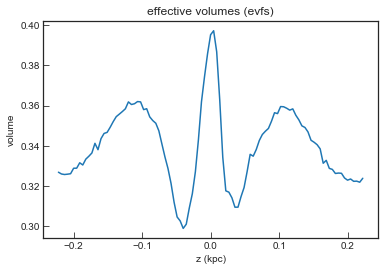

('star count after cut ', 35443)


In [9]:
star_Cat = "F"
zNBin_evfs = 100

file_evfs = "evfs_" + star_Cat + ".txt"
to_load_evfs = False
to_save_evfs = True

zRangeList = []
evfs_out = []
 
data_list = []
err_list = []
binz_list = []

print("Star Category: ", star_Cat)
zStepWidth = 2*z_cyl_cut/(zNBin_evfs-1)
zspace_evfs = np.linspace(-z_cyl_cut-zStepWidth/2., z_cyl_cut+zStepWidth/2., zNBin_evfs+1)

if to_load_evfs:
   print("Loaded evfs file: ", file_evfs)
   zRangeList, evfs_out = load_evfs(filename=file_evfs)
else:  
   evfs_cuts = cut_evfs(star_Cat, sp, jk, mj, tgas)
   mj_evfs = cut_flow(mj, evfs_cuts)
   jk_evfs = cut_flow(jk, evfs_cuts)
   _ , evfs_out = generate_evfs(mj_evfs, jk_evfs, star_Cat, zspace = zspace_evfs, filename=file_evfs, save=to_save_evfs)

plt.plot(zspace_evfs, evfs_out)
plt.ylabel("volume"); plt.xlabel("z (kpc)"); plt.title("effective volumes (evfs)")
plt.show()

print( 'star count after cut ', len(mj_evfs) ) 

Further cut the stars so that only the star category specified by the variable *star_Cat* remains. The evfs ( $\Theta_i$ ) previous generated are stored as *evfs_weights* $w_i = \Theta_i^{-1}$, which then will be stored in the output density file to be used to generate the physical star density.

The code behind the commented line-breaker is just for the plots in this ipynb, and does no effect on the calculations that follow.

('Best-fit velocity h = ', 0.092192806167175137, ' +/- ', 8.6966036187615445e-06)


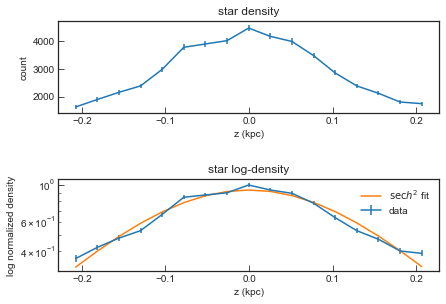

('star count after cut ', 16959)


In [10]:
def cut_stars(starCat, sp, jk, mj, tgas): # category cut and volume cut
   tightness = False
   cut_indx = []

   jk_color_cut_upper, jk_color_cut_lower = find_jk_boundaries(starCat, sp)
   #color_cut =  (jk > jk_color_cut_upper)*(jk < jk_color_cut_lower)*(tgas['parallax']/tgas['parallax_error'] > (is_good_relplx(mj)))*(jk != 0.)
   color_cut =  (jk > jk_color_cut_upper)*(jk < jk_color_cut_lower)*(tgas['parallax'] > min_plx)*(jk != 0.)
    
   jk = jk[color_cut]
   mj = mj[color_cut]
   tgas = tgas[color_cut]

   good_mj_cut = ( mj > main_sequence_cut_r(jk,tight=tightness))*(mj < main_sequence_cut_r(jk,low=True,tight=tightness))

   return [color_cut, good_mj_cut]


if dereddening:
   stars_cut = cut_stars(star_Cat, sp, jk_corr, mj_corr, tgas_cyl)
if not dereddening:
   stars_cut = cut_stars(star_Cat, sp, jk_cyl, mj_cyl, tgas_cyl)
stars_categorized = cut_flow(tgas_cyl, stars_cut)
jk_categorized = cut_flow(jk_cyl, stars_cut)
mj_categorized = cut_flow(mj_cyl, stars_cut)

ldeg = stars_categorized['l']
bdeg = stars_categorized['b']
plx = stars_categorized['parallax']
XYZ= bovy_coords.lbd_to_XYZ(ldeg, bdeg, 1./plx, degree=True)
z_kpc= XYZ[:,2]
z_pc = XYZ[:,2]*1000.

zRangeList_upper = zspace_evfs + zStepWidth/2
zRangeList_lower = zspace_evfs - zStepWidth/2
evfs_weight = np.array([])
for i, z_i in enumerate(z_kpc):
   zPosition_indx = (z_i < zRangeList_upper)*(z_i >= zRangeList_lower)
   if np.sum(zPosition_indx) == 0:
      print(("star at z = ", z_i, " kpc is out of evfs range!"))
   evfs_weight = np.append(evfs_weight, 1./evfs_out[zPosition_indx] )

#-----------------------------------------------------------------------------

dz_plt=0.025

zspace_hist_plt = np.linspace( -z_cyl_cut,z_cyl_cut, int(2*z_cyl_cut/dz_plt)+1 )
stars_plt_evfs, _, _ = plt.hist(z_kpc, zspace_hist_plt, weights=evfs_weight)
stars_plt_evfs_err, _ , _ = plt.hist(z_kpc, zspace_hist_plt)
for i, z_err in enumerate(stars_plt_evfs_err):
   if z_err == 0:
      continue
   else :
      stars_plt_evfs_err[i] = stars_plt_evfs[i]/np.sqrt(z_err)
plt.clf()

_ , (ax1, ax2) = plt.subplots(2, 1); plt.tight_layout(h_pad=5)

bins_plt = (zspace_hist_plt + dz_plt/2.)[:-1]
ax1.errorbar(bins_plt, stars_plt_evfs, yerr=stars_plt_evfs_err, capthick=2)
ax1.set_title("star density"); ax1.set_xlabel("z (kpc)"); ax1.set_ylabel("count")

plt_norm = stars_plt_evfs[int(len(bins_plt)/2)]
stars_plt_evfs_normed = stars_plt_evfs/plt_norm
stars_plt_evfs_err_normed = stars_plt_evfs_err/plt_norm
sechsq = lambda x, h, k: (0.25*k/h)*(np.cosh(x/(2.*h)) )**(-2)
h_fit, h_fit_err = optimize.curve_fit( sechsq, bins_plt, stars_plt_evfs_normed ,  sigma=stars_plt_evfs_err_normed)
print("Best-fit velocity h = ", h_fit[0], " +/- ", h_fit_err[0,0])
ax2.errorbar(bins_plt, stars_plt_evfs_normed, yerr=stars_plt_evfs_err_normed, capthick=2, label="data")
ax2.plot( bins_plt, sechsq(bins_plt, h_fit[0], h_fit[1]), label="$\sech^2$ fit")
ax2.set_yscale('log'); ax2.legend();
                                 
ax2.set_title("star log-density"); ax2.set_ylabel("log normalized density"); ax2.set_xlabel("z (kpc)");
plt.show()

print( 'star count after cut ', len(stars_categorized) ) 

Generate the proper motion from the ICRS coordiates (RA, Dec) to the galactic coordiates ( l, b ), which we will use to calculate the radial velocity.

In [11]:
save_file_density = star_Cat + '_stars.txt'

def ProperMotionTransform(ra_coord, dec_coord, pmra_coord, pmdec_coord):
   pmra_coord_cosdec = pmra_coord
   icrs = ICRS(ra=ra_coord*units.degree, dec=dec_coord*units.degree, pm_ra_cosdec=pmra_coord_cosdec*units.mas/units.yr, pm_dec=pmdec_coord*units.mas/units.yr)
   galactic = icrs.transform_to(Galactic)
   pml = (galactic.pm_l_cosb)/np.cos(galactic.b.radian)/(units.mas/units.yr)
   pmb = galactic.pm_b/(units.mas/units.yr)
   return (pml, pmb)

radeg = stars_categorized['ra']
decdeg = stars_categorized['dec']
pmra = stars_categorized['pmra']
pmdec = stars_categorized['pmdec']

pml, pmb = ProperMotionTransform(radeg, decdeg, pmra, pmdec)

We calculate the measurement uncertainties (ony $\delta z =$ *ErrZcoord* at the moment).

All the information is output to the star density file (*save_file_density*), which will be the density data to compared with the prediction by the Poisson-Jeans solver.

('Data saved to ', 'F_stars.txt')


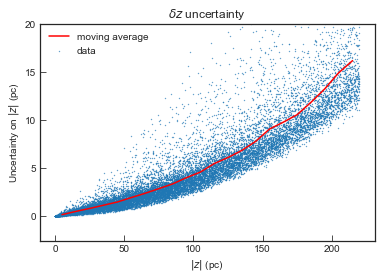

In [12]:
hipID = stars_categorized['hip']
e_plx = stars_categorized['parallax_error']
err_pml = [0.  for k in range(len(stars_categorized)) ]
covpm = [0.  for k in range(len(stars_categorized)) ]

bRad = bdeg*np.pi/180.
ErrZcoord = np.abs(np.divide(1000.,plx**2)*np.sin(bRad)*e_plx)


if dereddening:
   data = np.transpose( np.array([hipID,ldeg,bdeg,plx,e_plx,z_pc,evfs_weight, jk_categorized,mj_categorized, \
   mj_corr_categorized,jk_corr_categorized, pml,pmb,err_pml,covpm,covpm,ErrZcoord]) )
else:
   data = np.transpose( np.array([hipID,ldeg,bdeg,plx,e_plx,z_pc,evfs_weight, jk_categorized,mj_categorized, \
   mj_categorized,jk_categorized, pml,pmb,err_pml,covpm,covpm,ErrZcoord]) )

line_header = "# HpID, l (deg), b (deg), plx (mas), err_plx (mas), z_coord (pc), evfs_w, (B-V), AbsMag, AbsMag Corrected, \
(B-V) Corrected, pm_l (mas/yr), pm_b (mas/yr), err_pml (mas/yr) , err_pmb (mas/yr), cov_pmlpmb, err_z_coord (pc)"

np.savetxt(save_file_density, data, delimiter=',',header=line_header)

print("Data saved to ", save_file_density)

#-----------------------------------------------------------------------------------------------------------------

dz_mving_avg_plt=10; 
zspace_hist_plt = np.linspace( 0. ,z_cyl_cut*1000., int(z_cyl_cut*1000./dz_mving_avg_plt)+1 )
stars_zerr_plt, _, _ = plt.hist(np.abs(z_pc), zspace_hist_plt, weights=ErrZcoord)
stars_zerr_plt_norm, _, _ = plt.hist(np.abs(z_pc), zspace_hist_plt)
plt.clf()

plt.scatter(np.abs(z_pc), ErrZcoord, s = 0.1, label='data')
plt.plot(zspace_hist_plt[:-1]+dz_mving_avg_plt/2, stars_zerr_plt/stars_zerr_plt_norm, color='red', label='moving average')
plt.legend()

plt.title("$\delta z$ uncertainty"); plt.ylabel("Uncertainty on $|z|$ (pc)"); plt.xlabel("$|z|$ (pc)"); plt.ylim(ymax=20)
plt.show()

## Midplane velocity profile
<br />

<font color='red'> **All the modules in this section will be moved to the Poisson-Jeans analysis code in the next release. The reason is to allow for a variable sun height to be used in the likelihood calculation.** </font>

We now preceed to generate the mid-plane star's velocity profile, which will be critical as an input to the Poisson-Jeans solver to generate the density prediction. Here, the definition of "mid-plane" is specified by the variable *midplane_b_deg*, which cuts the star density in galactic *b* in degree.

The following code runs the result base the star sample generated by the density code above. So it is mandatory to run the code from above first, then to proceed with the midplane code.

First, we cut away stars with |b| > *midplane_b_deg*.

In [13]:
midplane_b_deg = 5.

def cut_midplane(tgas, b_cut = 5., r_cut = 0.15, z_cut = 0.20):

   vol_cut_indx = cut_indx_vol(tgas, r_cut, z_cut)
   tgas = tgas[vol_cut_indx]
   midplane_indx = (np.abs(tgas['b']) <= b_cut)

   return [vol_cut_indx, midplane_indx]


midplane_cut = cut_midplane(stars_categorized, b_cut=midplane_b_deg)
stars_midplane = cut_flow(stars_categorized, midplane_cut)
ldeg_midplane = cut_flow(ldeg, midplane_cut)
bdeg_midplane = cut_flow(bdeg, midplane_cut)
pml_midplane = cut_flow(pml, midplane_cut)
pmb_midplane = cut_flow(pmb, midplane_cut)
plx_midplane = cut_flow(plx, midplane_cut)
evfs_weight_midplane = cut_flow(evfs_weight, midplane_cut)
    
lRad_midplane = ldeg_midplane*np.pi/180.
bRad_midplane = bdeg_midplane*np.pi/180.

print("Star count after mid-plane cut: ", len(stars_midplane))

('Star count after mid-plane cut: ', 1284)


Getting the *w*-velocity profile. Here we use an ad-hoc $w_{\text{Sun}} = 7.01$ km/s extracted from the mean of the tracer velocity profiles. *wSun* as a nuissance parameter will be introduced in the next release . The velocity distributions with estimated $\overline{V}_r = \langle V_r \rangle$ and $\overline{V}_r = 0$ are shown in the plots.

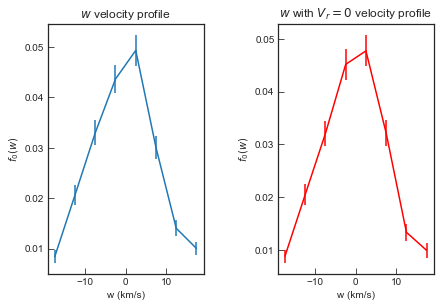

In [14]:
vKappa = 4.74047 #( km s^-1 mas (mas yr)^-1 )
wSun = 7.01
uSun = 11.1
vSun = 12.24
RVMean = -uSun*np.cos(lRad_midplane)*np.cos(bRad_midplane) - vSun*np.sin(lRad_midplane)*np.cos(bRad_midplane) - wSun*np.sin(bRad_midplane)
VZ =  wSun + vKappa*pmb_midplane*np.cos(bRad_midplane)/plx_midplane + RVMean*np.sin(bRad_midplane)

#----------------------------------------------------------------------------------------------------

dw_plt=5
w_range_plt = 20

VZ_meanless =  wSun + vKappa*pmb_midplane*np.cos(bRad_midplane)/plx_midplane

wspace_hist_plt = np.linspace( -w_range_plt, w_range_plt, int(2*w_range_plt/dw_plt)+1 )
bins_plt = (wspace_hist_plt + dw_plt/2.)[:-1]

w_stars_plt, _, _ = plt.hist(VZ, wspace_hist_plt, weights=evfs_weight_midplane)
norm_w_stars = np.trapz(w_stars_plt, x = bins_plt)
w_stars_err_plt, _ , _ = plt.hist(VZ, wspace_hist_plt)
for i, w_err in enumerate(w_stars_err_plt):
   if w_err == 0:
      continue
   else :
      w_stars_err_plt[i] = w_stars_plt[i]/np.sqrt(w_err)
w_stars_no_rv_plt, _, _ = plt.hist(VZ_meanless, wspace_hist_plt, weights=evfs_weight_midplane)
norm_w_no_rv_stars = np.trapz(w_stars_plt, x = bins_plt)
w_stars_no_rv_err_plt, _ , _ = plt.hist(VZ_meanless, wspace_hist_plt)
for i, w_err in enumerate(w_stars_no_rv_err_plt):
   if w_err == 0:
      continue
   else :
      w_stars_no_rv_err_plt[i] = w_stars_no_rv_plt[i]/np.sqrt(w_err)
plt.clf()

_ , (ax1, ax2) = plt.subplots(1, 2); plt.tight_layout(w_pad=5)

bins_plt = (wspace_hist_plt + dw_plt/2.)[:-1]
ax1.errorbar(bins_plt, w_stars_plt/norm_w_stars, yerr=w_stars_err_plt/norm_w_stars, capthick=2)
ax1.set_title("$w$ velocity profile"); ax1.set_ylabel("$f_0(w)$"); ax1.set_xlabel("w (km/s)");
ax2.errorbar(bins_plt, w_stars_no_rv_plt/norm_w_no_rv_stars, yerr=w_stars_no_rv_err_plt/norm_w_no_rv_stars, capthick=2, color='red')
ax2.set_title("$w$ with $V_r=0$ velocity profile"); ax2.set_ylabel("$f_0(w)$"); ax2.set_xlabel("w (km/s)");
plt.show()

The final step is to bin all the mid-plane stars in the w-space into *wNBin* bins within a randge of (0,*w_Range*). The array of unnormalized binned stars is output to the file *file_w0*, which then will be processed by the Poisson-Jeans solver for star density prediction.

A gaussian fit for the $f_0(|w|)$ is shown. The actual fitting for the Poisson-Jeans solver purpose is done in the analysis program, not in this module.

('Mid-plane velocity saved to: ', 'F_stars_w_midplane.txt')
('Best-fit velocity sigma = ', array([ 10.45738107]), ' +/- ', array([[ 0.21262717]]))


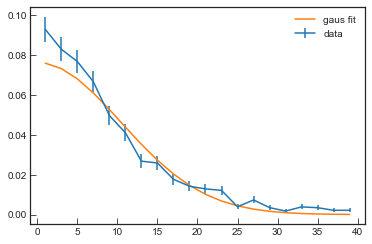

In [15]:
to_save_file_w0 = True
file_w0 = star_Cat + '_stars_w_midplane.txt'
wNBin = 20
w_Range = 40.


delw = w_Range/wNBin
vz_err = np.zeros_like(VZ)

w_space = np.linspace(0., w_Range, wNBin+1)
w0_bin_stars, _, _ = plt.hist(np.abs(VZ), w_space, weights=evfs_weight_midplane)
w0_bin_stars_err, _ , _ = plt.hist(np.abs(VZ), w_space)
for i, w_err in enumerate(w0_bin_stars_err):
   if w_err == 0:
      continue
   else :
      w0_bin_stars_err[i] = w0_bin_stars[i]/np.sqrt(w_err)
plt.clf()
bins_w = (w_space + delw/2.)[:-1]

if to_save_file_w0:
   w0data = np.transpose( np.array([bins_w, w0_bin_stars, w0_bin_stars_err]) )
   line_header = "# w bins (km/s), count, count_err"
   np.savetxt(file_w0, w0data, delimiter=',',header=line_header)
   print("Mid-plane velocity saved to: ", file_w0)

#----------------------------------------------------------------------------------
w_norm = np.trapz(w0_bin_stars, x=bins_w)
for i, w_err in enumerate(w0_bin_stars_err):
   if w_err == 0:
      w0_bin_stars_err[i] = 1.
w0_bin_stars_normed = w0_bin_stars/w_norm; w0_bin_stars_err_normed = w0_bin_stars_err/w_norm;
plt.errorbar(bins_w, w0_bin_stars_normed, yerr=w0_bin_stars_err_normed, capthick=2, label="data")

gaus = lambda x, s: (2./(s*np.sqrt(2.*np.pi)) )*np.exp(-0.5*(x/s)**2)

sigma, sigma_err = optimize.curve_fit( gaus, bins_w, w0_bin_stars_normed,  sigma=w0_bin_stars_err_normed, p0=10)
print("Best-fit velocity sigma = ", sigma, " +/- ", sigma_err)
plt.plot(bins_w, gaus(bins_w, sigma), label="gaus fit")
plt.legend()
plt.show()